# Load Modules

In [57]:
%matplotlib inline

import warnings
from copy import deepcopy
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.stats import (threshold, 
                           align,
                           fdr, 
                           isc,
                           _calc_pvalue)
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import _calc_pvalue, align_states, circle_shift

from fnl_tools.utils import get_rect_coord,rec_to_time
from fnl_tools.plotting import plot_recurrence
from fnl_tools.stats import (compute_ISC_all_roi,
                             create_average_concordance
                            )

from nilearn.plotting import plot_glass_brain

from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances

from scipy.stats import pearsonr

warnings.filterwarnings('ignore')

# base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
base_dir = '/Volumes/Engram/Data/vmpfc/'


# Load Parcellation Mask

In [7]:
mask = Brain_Data(os.path.join(base_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

# Temporal Intersubject Synchrony


## Study 1

Plotting unthresholded image


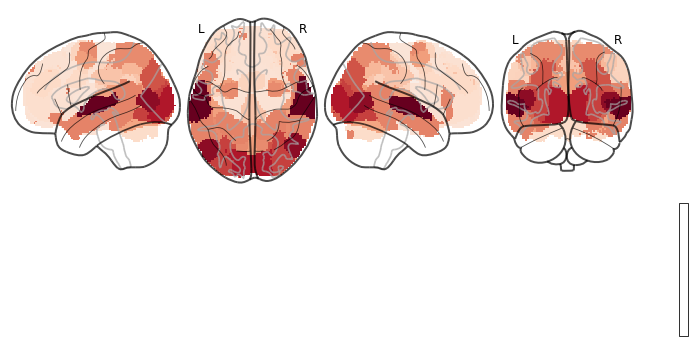

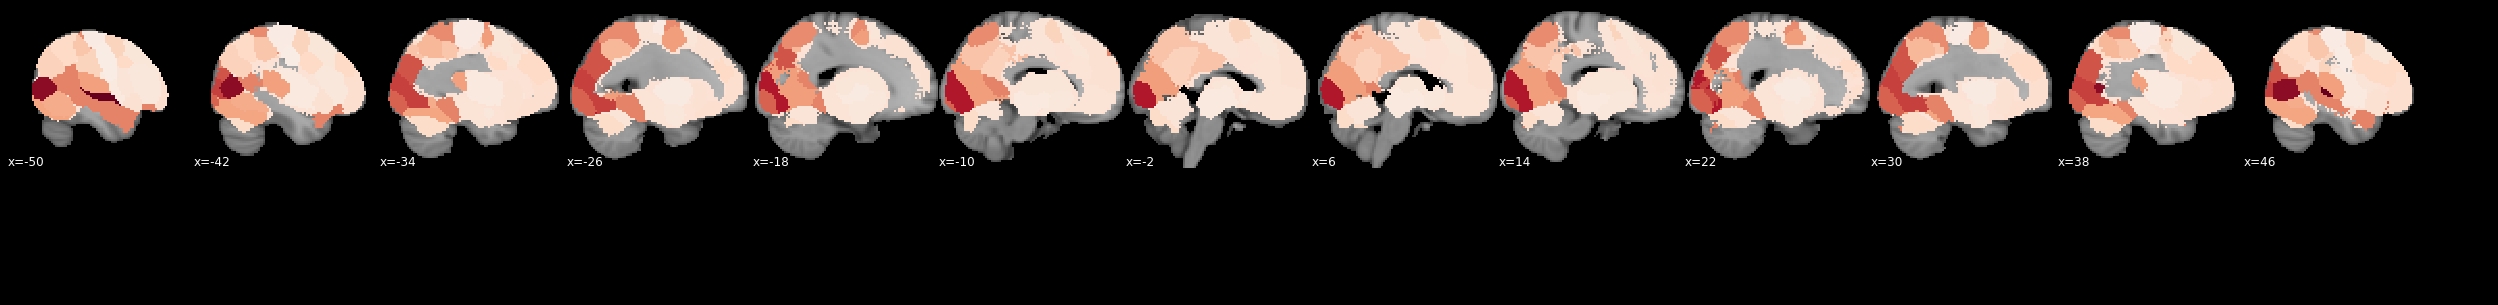

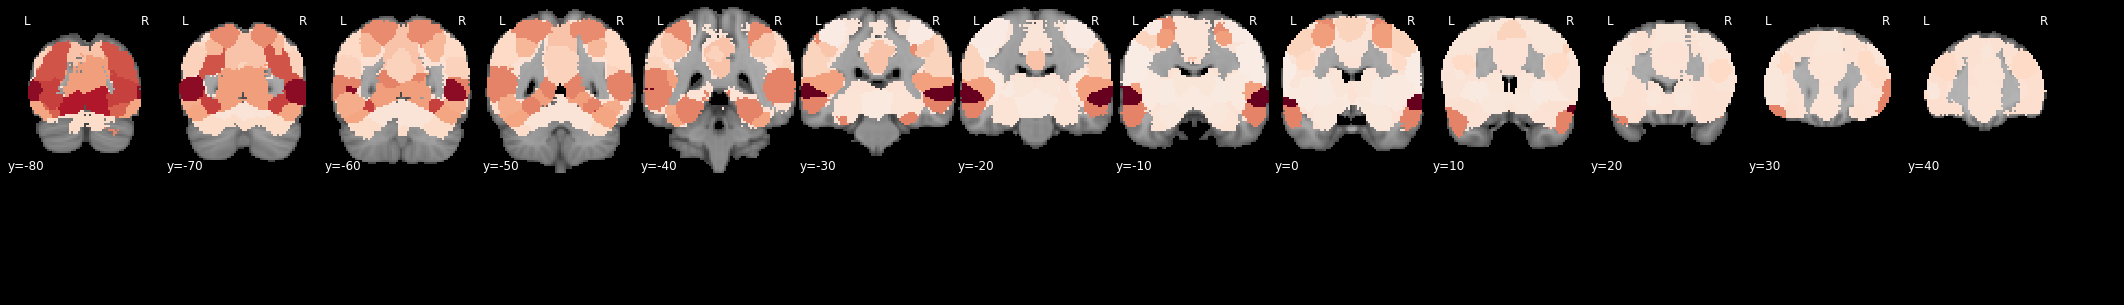

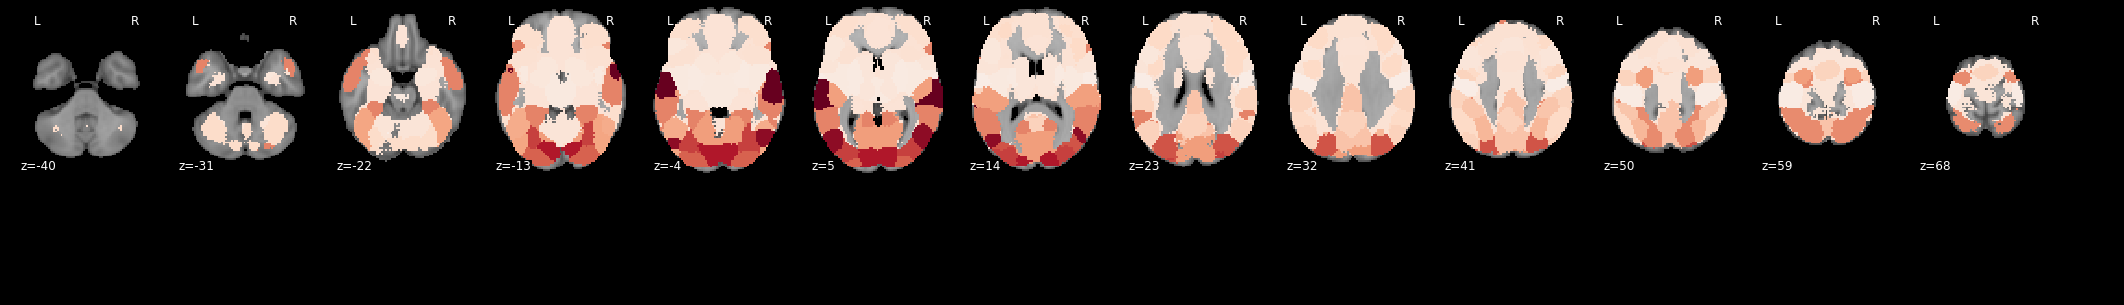

In [12]:
study = 'Study1'

r_brain, p_brain = compute_ISC_all_roi(os.path.join(base_dir, 'Data', study, 'Denoised_ROI'), mask_x)

r_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_ISC_r.nii.gz'))
p_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_ISC_p.nii.gz'))

r_brain.plot(view='full')

## Study 2

In [21]:
study = 'Study2'

r_brain, p_brain = compute_ISC_all_roi(os.path.join(base_dir, 'Data', study, 'Denoised_ROI'), mask_x)

r_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_ISC_r.nii.gz'))
p_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_ISC_p.nii.gz'))

100%|██████████| 50/50 [34:17<00:00, 41.15s/it]


Plotting unthresholded image


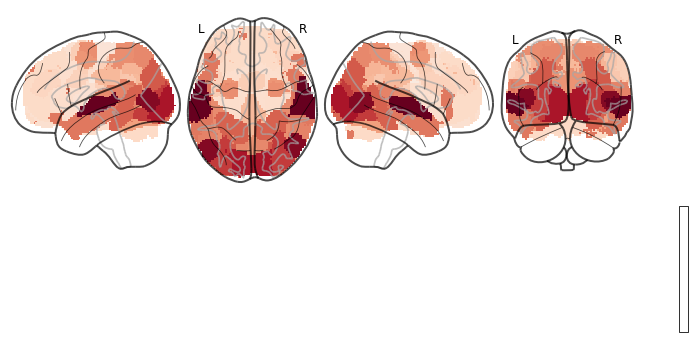

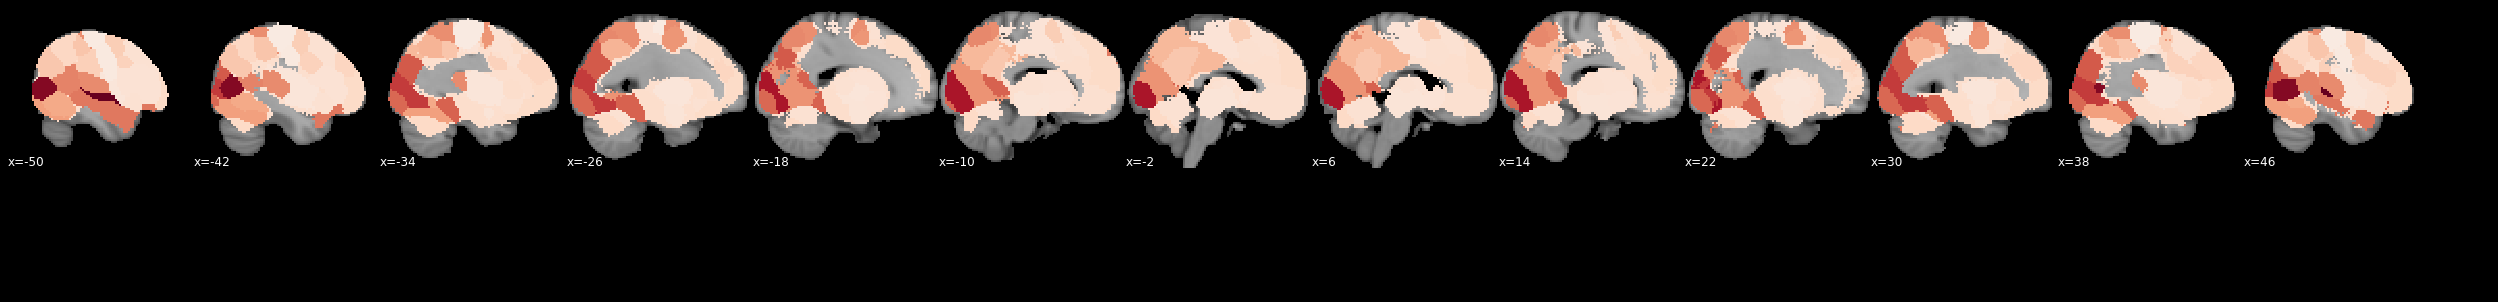

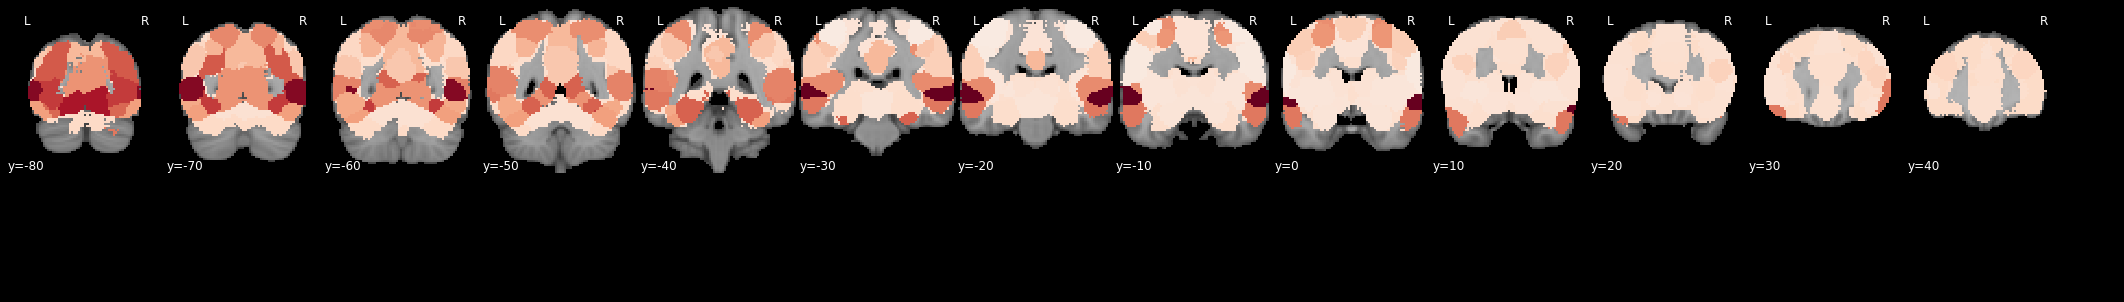

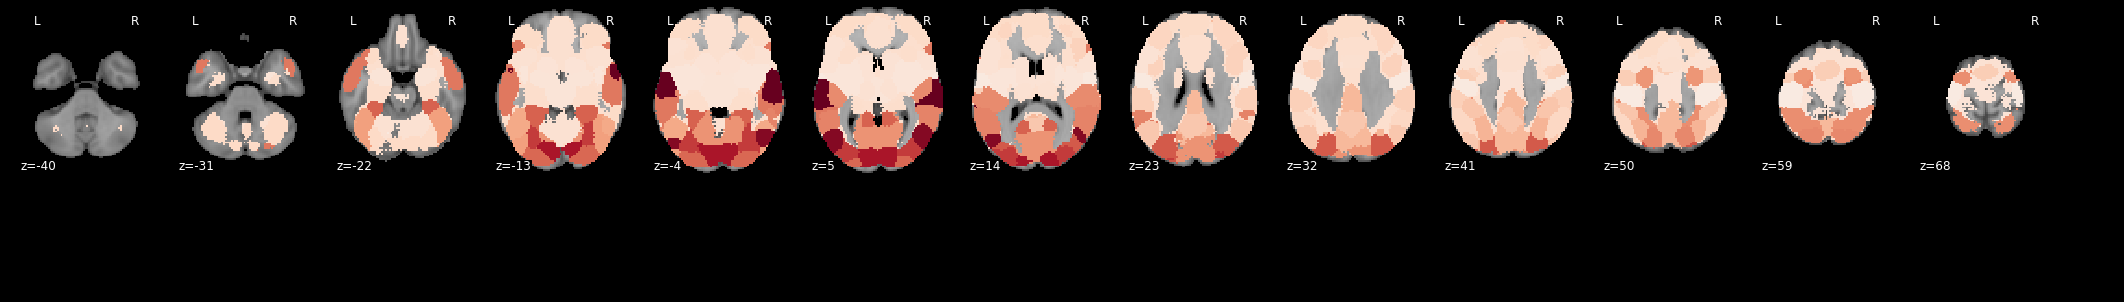

In [24]:
r_brain.plot(view='full')

## Make figures for paper

Study1, Max r=0.45
Study2, Max r=0.44


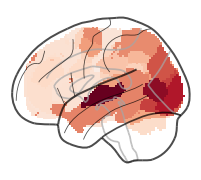

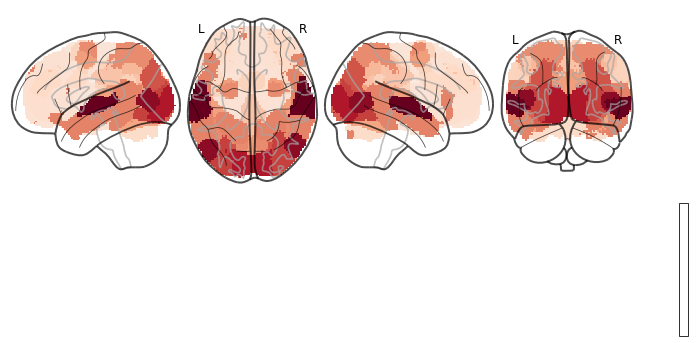

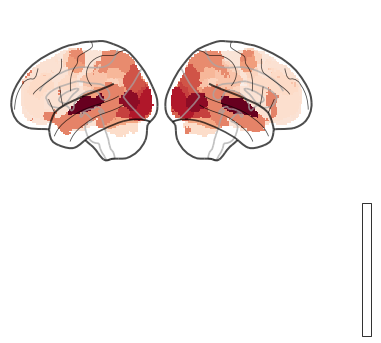

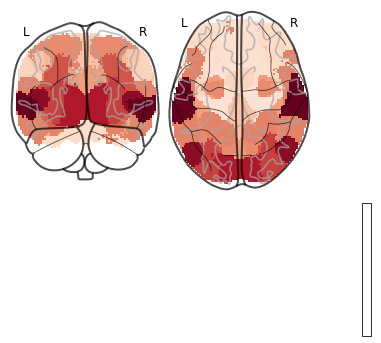

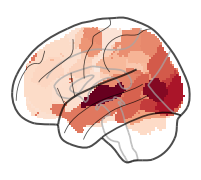

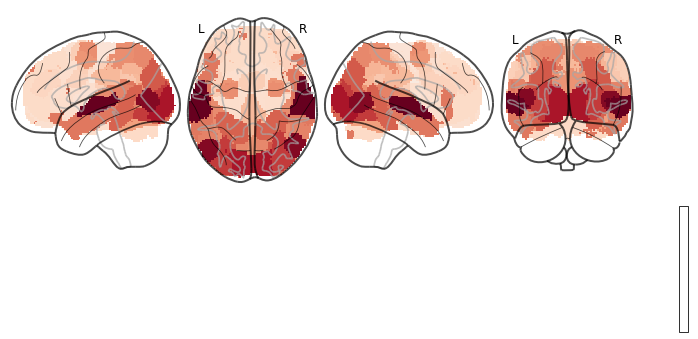

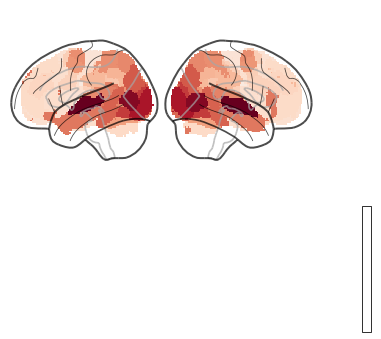

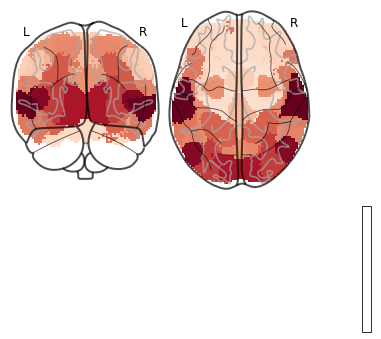

In [23]:

for study in ['Study1', 'Study2']:
    isc_r = Brain_Data(os.path.join(base_dir,'Analyses', 'ISC', f'{study}_Temporal_ISC_r.nii.gz'))
    print(f"{study}, Max r={isc_r.data.max():.02}")
    cmap = 'RdBu_r'

    plot_glass_brain(isc_r.to_nifti(), display_mode='l', colorbar=False, cmap=cmap, plot_abs=False)
    plt.savefig(os.path.join(base_dir, 'Figures', 'ISC', f'{study}_ISC_Brain_Left_Figure.pdf'))
    plt.savefig(os.path.join(base_dir, 'Figures', 'ISC', f'{study}_ISC_Brain_Left_Figure.png'), dpi=300)

    plot_glass_brain(isc_r.to_nifti(), display_mode='lzry',colorbar=True,cmap=cmap,plot_abs=False)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Figure.png'), dpi=300)

    plot_glass_brain(isc_r.to_nifti(), display_mode='lr',colorbar=True,cmap=cmap,plot_abs=False)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Lateral_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Lateral_Figure.png'), dpi=300)

    plot_glass_brain(isc_r.to_nifti(), display_mode='yz',colorbar=True,cmap=cmap,plot_abs=False)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Medial_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ISC_Brain_Medial_Figure.png'), dpi=300)

### Calculate spatial similarity between two datasets

In [6]:
s1_isc = Brain_Data(os.path.join(base_dir,'Analyses', 'ISC', 'Study1_Temporal_ISC_r.nii.gz'))
s2_isc = Brain_Data(os.path.join(base_dir,'Analyses', 'ISC', 'Study2_Temporal_ISC_r.nii.gz'))
s1_roi = [s1_isc.apply_mask(mask=x).mean() for x in mask_x]
s2_roi = [s2_isc.apply_mask(mask=x).mean() for x in mask_x]

pearsonr(s1_roi, s2_roi)


(0.9970890985264071, 2.5495975892838442e-55)

### Compute ISC descriptive stats for Paper

In [26]:
episode = 'ep01'

all_stats = {}
for study in ['Study1', 'Study2']:
    for roi in [4, 32]:
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, 'Denoised_ROI', f'*{episode}*ROI{roi}.csv'))
        mn = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[0]
            dat = pd.read_csv(f)
            mn[sub] = dat.T.mean()
        mn = pd.DataFrame(mn)

        temporal_isc = Adjacency(1 - pairwise_distances(mn.T, metric='correlation'), matrix_type='Similarity')
        stats = temporal_isc.isc(metric='mean')
        all_stats[f'{study}_{roi}'] = stats
        print(f"{study}, ROI-{roi} Mean: {stats['isc']:.02}, p = {stats['p']}, std={temporal_isc.std():.02}")
        
        sns.heatmap(temporal_isc.squareform() + np.diag(np.ones(temporal_isc.square_shape()[0])), xticklabels=False, yticklabels=False, vmin=-1, vmax=1, square=True, cmap='RdBu_r', cbar=False)
        plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_ROI{roi}_ISC.pdf'))
        plt.close()

Study1, ROI-4 Mean: 0.38, p = 0.0001999600079984003, std=0.13
Study1, ROI-32 Mean: 0.06, p = 0.0001999600079984003, std=0.07
Study2, ROI-4 Mean: 0.35, p = 0.0001999600079984003, std=0.13
Study2, ROI-32 Mean: 0.073, p = 0.0001999600079984003, std=0.052


# Hyperalign Pilot data
## Align Study 1 episode 2 to 1000 dimensional space for each ROI 

In [67]:
n_features = 1000
roi = 32
episode = 'ep02'

for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI', f'*{episode}_Denoised_ROI{roi}.csv'))
    sub_list = [os.path.basename(x).split('_')[0] for x in file_list]

    # Hyperalign
    data = []
    for f in file_list:
        data.append(pd.read_csv(f))
    data = [np.array(x) for x in data]
    aligned = align(data, method='deterministic_srm', n_features=n_features)

    # Write Out
    common = pd.DataFrame(aligned['common_model'].T)
    common.to_csv(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'Common_Model_{episode}_features{n_features}_ROI{roi}.csv'), index=False)
    for i,sub in enumerate(sub_list):
        transformed = pd.DataFrame(aligned['transformed'][i].T)
        transformed.to_csv(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'{sub}_hyperaligned_{episode}_features{n_features}_ROI{roi}.csv'), index=False)
        trans = pd.DataFrame(aligned['transformation_matrix'][i])
        trans.to_csv(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'{sub}_transformation_matrix_{episode}_features{n_features}_ROI{roi}.csv'), index=False)


In [64]:
np.dot(data[0], aligned['transformation_matrix'][0]).shape

(1317, 1000)

## Transform each Study 1 Episode 1 ROI to shared 1000 dimensional space based on Episode 2 Transformation matrices


In [80]:
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'*_transformation_matrix_ep02_features{n_features}_ROI{roi}.csv'))
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        trans = pd.read_csv(f)
        sdat = pd.read_csv(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI', f'{sub}_ep01_Denoised_ROI{roi}.csv'))
        trans_sdat = pd.DataFrame(np.dot(sdat, trans)).to_csv(os.path.join(base_dir,'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'{sub}_hyperaligned_ep01_features{n_features}_ROI{roi}.csv'), index=False)


100%|██████████| 50/50 [49:30<00:00, 59.41s/it]


## Calculate Temporal ISC on Hyperaligned Pilot Data

100%|██████████| 50/50 [05:30<00:00,  6.62s/it]


Plotting unthresholded image


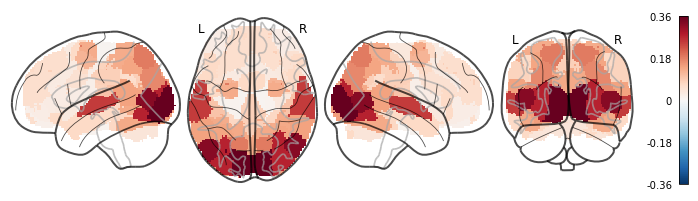

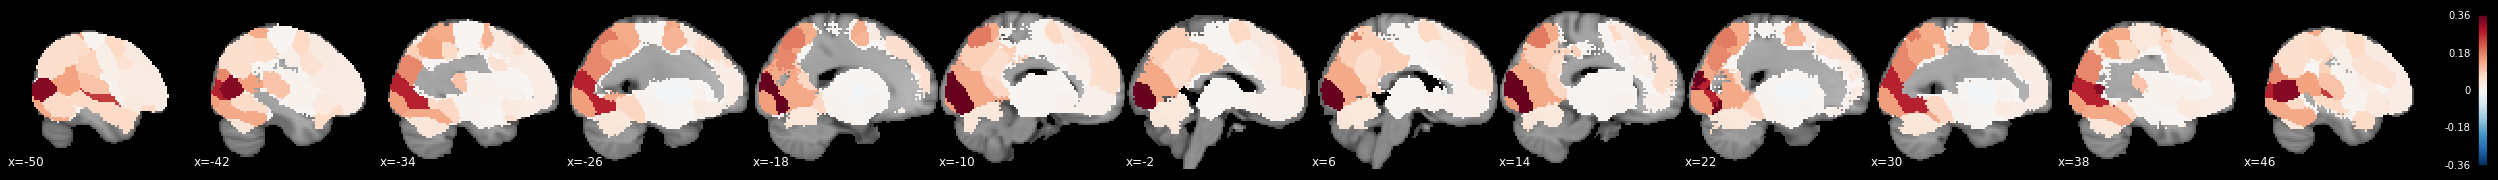

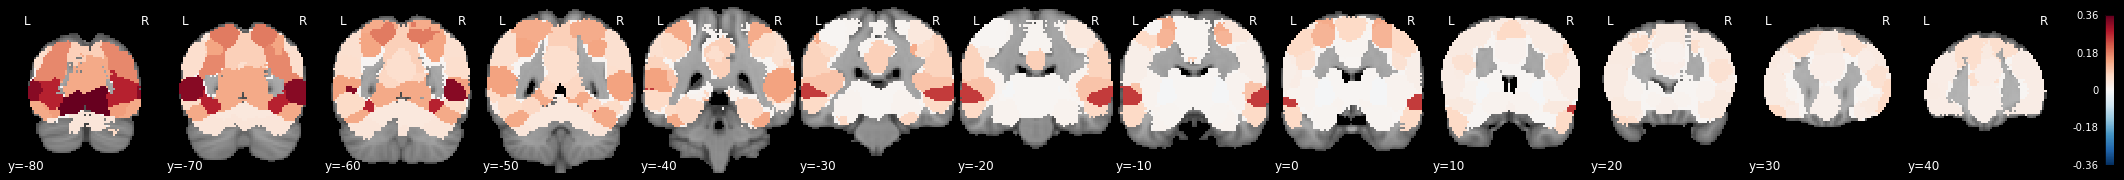

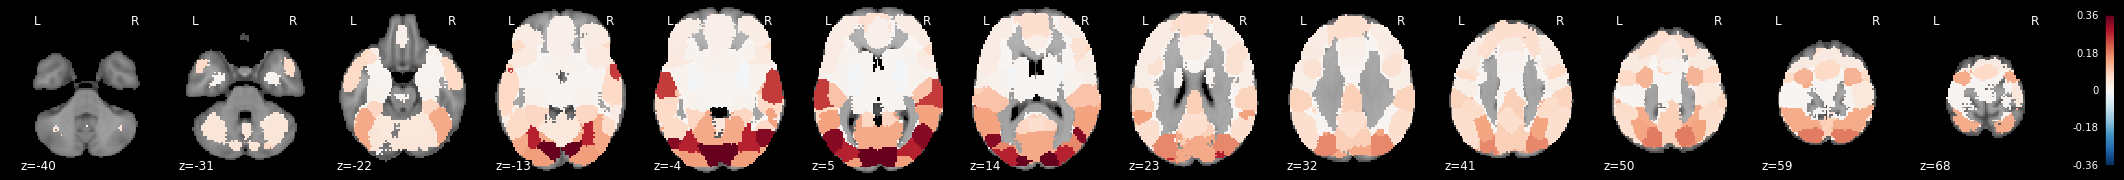

In [158]:
study = 'Study1'

r_brain, p_brain = compute_ISC_all_roi(os.path.join(base_dir, 'Data', study, 'Denoised_ROI_Hyperaligned'), mask_x, episode='ep01')
r_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Hyperaligned_Temporal_ISC_r.nii.gz'))
p_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Hyperaligned_Temporal_ISC_p.nii.gz'))

r_brain.plot(view='full')

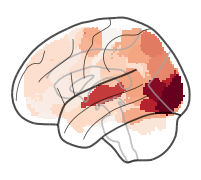

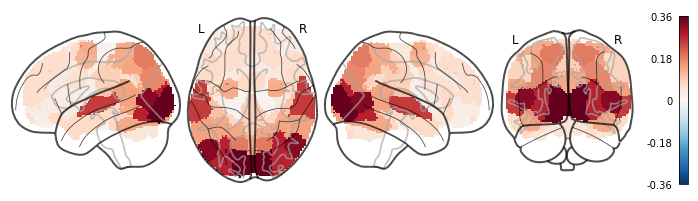

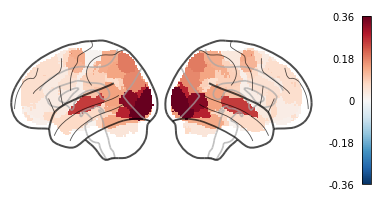

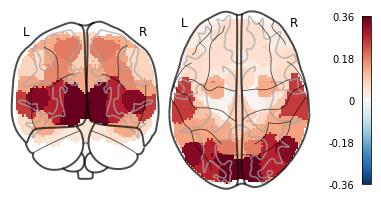

In [15]:
study = 'Study1'
isc_r = Brain_Data(os.path.join(base_dir,'Analyses', 'ISC', f'{study}_Hyperaligned_Temporal_ISC_r.nii.gz'))

cmap = 'RdBu_r'

plot_glass_brain(isc_r.to_nifti(), display_mode='l', colorbar=False, cmap=cmap, plot_abs=False)
plt.savefig(os.path.join(base_dir, 'Figures', 'ISC', f'{study}_Hyperaligned_ISC_Brain_Left_Figure.pdf'))

plot_glass_brain(isc_r.to_nifti(), display_mode='lzry',colorbar=True,cmap=cmap,plot_abs=False)
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_Hyperaligned_ISC_Brain_Figure.pdf'))

plot_glass_brain(isc_r.to_nifti(), display_mode='lr',colorbar=True,cmap=cmap,plot_abs=False)
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_Hyperaligned_ISC_Brain_Lateral_Figure.pdf'))

plot_glass_brain(isc_r.to_nifti(), display_mode='yz',colorbar=True,cmap=cmap,plot_abs=False)
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'{study}_Hyperaligned_ISC_Brain_Medial_Figure.pdf'))

# Where does hyperalignment improve ISC?
Here we need to subtract differences between ISC then compute median difference in subject wise bootstrap for each ROI

In [145]:
n_bootstraps = 5000
study = 'Study1'
episode = 'ep01'

diff_median = False

def bootstrap_subject_matrix_differences(matrix1, matrix2, random_state=None):
    '''This function shuffles subjects within two similarity matrices based 
    on recommendation by Chen et al., 2016. returns bootrapped versions of each
    '''
    if matrix1.shape != matrix2.shape:
        raise ValueError("matrix1 and matrix2 must be the same size.")
        
    random_state = check_random_state(random_state)
    n_sub = matrix1.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return (matrix1[bootstrap_subject, :][:, bootstrap_subject], matrix2[bootstrap_subject, :][:, bootstrap_subject])

r_diff = {}
p_diff = {}
for roi in tqdm(range(50)):
    file_list1 = glob.glob(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI', f'*{episode}*ROI{roi}.csv'))
    file_list1.sort()
    file_list2 = glob.glob(os.path.join(base_dir, 'Data', 'Study1', 'Denoised_ROI_Hyperaligned', f'*{episode}*ROI{roi}.csv'))
    file_list2.sort()

    mn1 = {}
    mn2 = {}
    for f1,f2 in zip(file_list1, file_list2):
        sub = os.path.basename(f1).split('_')[0]
        dat1 = pd.read_csv(f1)
        dat2 = pd.read_csv(f2)
        mn1[sub] = dat1.T.mean()
        mn2[sub] = dat2.T.mean()
    mn1 = pd.DataFrame(mn1)
    mn2 = pd.DataFrame(mn2)

    sim1 = 1 - pairwise_distances(mn1.T, metric='correlation')
    sim2 = 1 - pairwise_distances(mn2.T, metric='correlation')

    if not diff_median:
        obs_diff = Adjacency(sim2 - sim1, matrix_type='similarity').median()
    else:
        obs_diff = Adjacency(sim2, matrix_type='similarity').median() - Adjacency(sim1, matrix_type='similarity').median()

    median_diff = []
    for sample in range(n_bootstraps):
        boot_sim1, boot_sim2 = bootstrap_subject_matrix_differences(sim1, sim2)
        if not diff_median:
            boot_sim1 = Adjacency(boot_sim1, matrix_type='similarity')
            boot_sim2 = Adjacency(boot_sim2, matrix_type='similarity')
            boot_sim1.data[boot_sim1.data == 1] = np.nan
            boot_sim2.data[boot_sim2.data == 1] = np.nan
            median_diff.append((boot_sim2 - boot_sim1).median())
        else:
            median_diff.append(Adjacency(boot_sim2, matrix_type='similarity').median() - Adjacency(boot_sim1, matrix_type='similarity').median())
    r_diff[roi] = obs_diff
    p_diff[roi] = _calc_pvalue(median_diff, obs_diff, 2)
    
r_brain = roi_to_brain(pd.Series(r_diff), mask_x=mask_x)
p_brain = roi_to_brain(pd.Series(p_diff), mask_x=mask_x)

if not diff_median:
    r_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_vs_Hyperaligned_ISC_r_nboot{n_bootstraps}.nii.gz'))
    p_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_vs_Hyperaligned_ISC_p_nboot{n_bootstraps}.nii.gz'))
else:
    r_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_vs_Hyperaligned_ISC_r_nboot{n_bootstraps}_diff_median.nii.gz'))
    p_brain.write(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_Temporal_vs_Hyperaligned_ISC_p_nboot{n_bootstraps}_diff_median.nii.gz'))


100%|██████████| 50/50 [19:11<00:00, 23.02s/it]


In [ ]:
pilot = Brain_Data(os.path.join(base_dir,'Analyses','FNL_Pilot_ep01_Temporal_ISC.nii.gz'))
hyperaligned = Brain_Data(os.path.join(base_dir,'Analyses','FNL_Pilot_ep01_Temporal_ISC_Hyperaligned.nii.gz'))
pilot_roi = [pilot.apply_mask(mask=x).mean() for x in mask_x]
hyperaligned_roi = [hyperaligned.apply_mask(mask=x).mean() for x in mask_x]
pearsonr(hyperaligned_roi,pilot_roi)

# Spatial Intersubject Synchrony


## Calculate Spatial ISC over time without hyperalignment

In [55]:
roi = 32
study = 'Study2'
episode = 'ep01'

roi_isc = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(base_dir,'Data', study, 'Denoised_ROI',f'*{episode}*ROI{roi}.csv'))
    all_sub_dat = {}
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        all_sub_dat[sub] = pd.read_csv(f)
    isc = {}
    for i in range(1364):
        time_dat = {}
        for sub in all_sub_dat:
            time_dat[sub] = all_sub_dat[sub].iloc[i,:]
        time_dat = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat).T, metric='correlation'), matrix_type='similarity')
        isc[i] = time_dat.median()
    roi_isc[roi] = isc
pd.DataFrame(roi_isc).to_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'), index=False)

100%|██████████| 50/50 [53:31<00:00, 64.24s/it]   


In [ ]:
h = pd.read_csv(os.path.join(base_dir,'Analyses','ROI_Hyperaligned','Spatial_ISC_Hyperaligned.csv'),index_col=0)
# h['Alignment'] = 'Functional'
a = pd.read_csv(os.path.join(base_dir,'Analyses','ROI_Hyperaligned','Spatial_ISC_Anatomical.csv'),index_col=0)
# a['Alignment'] = 'Anatomical'
roi_isc = pd.concat([h,a],axis=1)
roi_isc.columns = ['Hyperaligned_vmPFC','Hyperaligned_V1','vmPFC','V1']
roi_isc.to_csv(os.path.join(base_dir,'Analyses','ROI_Hyperaligned','Spatial_ISC_Combined.csv'))
f,a = plt.subplots(1,figsize=(15,3))
roi_isc.plot(ax=a)
a.set_ylabel('Spatial ISC',fontsize=16)
a.set_xlabel('Time',fontsize=16)

## Calculate Spatial ISC over time with hyperalignment

In [211]:
roi = 32
study = 'Study1'
episode = 'ep01'

roi_isc = {}
for roi in tqdm(range(50)):
    file_list = glob.glob(os.path.join(base_dir,'Data', study, 'Denoised_ROI_Hyperaligned',f'*{episode}*ROI{roi}.csv'))
    all_sub_dat = {}
    for f in file_list:
        sub = os.path.basename(f).split('_')[0]
        all_sub_dat[sub] = pd.read_csv(f)
    isc = {}
    for i in range(1364):
        time_dat = {}
        for sub in all_sub_dat:
            time_dat[sub] = all_sub_dat[sub].iloc[i,:]
        time_dat = Adjacency(1 - pairwise_distances(pd.DataFrame(time_dat).T, metric='correlation'), matrix_type='similarity')
        isc[i] = time_dat.median()
    roi_isc[roi] = isc
pd.DataFrame(roi_isc).to_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'), index=False)

100%|██████████| 50/50 [08:04<00:00,  9.69s/it]


## Make plot combining ISC and Mean Timeseries

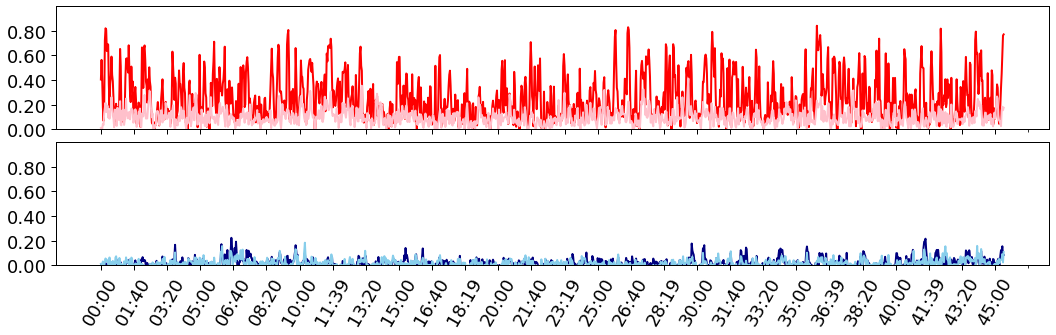

In [5]:
study = 'Study1'
episode = 'ep01'

spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'))
spatial_isc_hyper = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))

with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(nrows=2, figsize=(15,5),sharex=True)
    roi = 4
    spatial_isc_hyper.iloc[:, roi].plot(ax=a[0],linewidth=2,color=['red'],legend=False)
    spatial_isc.iloc[:, roi].plot(ax=a[0],linewidth=2,color=['pink'],legend=False)
    a[0].set_yticks([x for x in np.arange(0, 1., .2)])
    a[0].set_yticklabels(['{0:.2f}'.format(x) for x in a[0].get_yticks()],
                         rotation=0,fontsize=18)
    a[0].set_xticks(range(spatial_isc.index.min(), spatial_isc.index.max(), 50))
    a[0].set_xticklabels(rec_to_time(range(spatial_isc.index.min(), spatial_isc.index.max(),50), TR=2.0),
                         rotation=60,fontsize=18)
    a[0].set_ylim([0,1])
    
    roi = 32
    spatial_isc_hyper.iloc[:, roi].plot(ax=a[1],linewidth=2,color=['navy'],legend=False)
    spatial_isc.iloc[:, roi].plot(ax=a[1],linewidth=2,color=['skyblue'],legend=False)
    a[1].set_yticks([x for x in np.arange(0, 1., .2)])
    a[1].set_yticklabels(['{0:.2f}'.format(x) for x in a[1].get_yticks()],
                         rotation=0,fontsize=18)
    a[1].set_xticks(range(spatial_isc.index.min(), spatial_isc.index.max(), 50))
    a[1].set_xticklabels(rec_to_time(range(spatial_isc.index.min(), spatial_isc.index.max(), 50), TR=2.0),
                         rotation=60,fontsize=18)
    a[1].set_ylim([0,1])

    
    plt.tight_layout(pad=1, w_pad=.1, h_pad=.1)
    plt.savefig(os.path.join(base_dir,'Figures','ISC','Spatial_ISC_withalignment.pdf'))

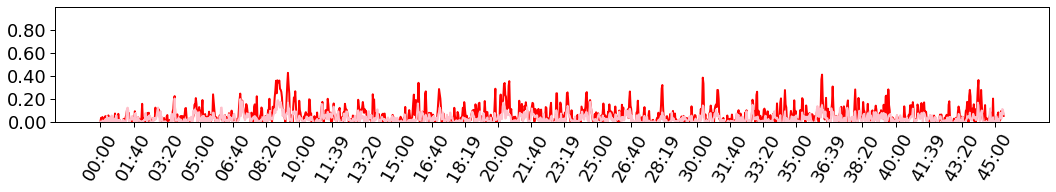

In [61]:
study = 'Study1'
episode = 'ep01'

spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'))
spatial_isc_hyper = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))

with sns.plotting_context(context='paper',font_scale=2):
    f,a = plt.subplots(nrows=1, figsize=(15,3),sharex=True)
    roi = 19
    spatial_isc_hyper.iloc[:, roi].plot(ax=a,linewidth=2,color=['red'],legend=False)
    spatial_isc.iloc[:, roi].plot(ax=a,linewidth=2,color=['pink'],legend=False)
    a.set_yticks([x for x in np.arange(0, 1., .2)])
    a.set_yticklabels(['{0:.2f}'.format(x) for x in a.get_yticks()],
                         rotation=0,fontsize=18)
    a.set_xticks(range(spatial_isc.index.min(), spatial_isc.index.max(), 50))
    a.set_xticklabels(rec_to_time(range(spatial_isc.index.min(), spatial_isc.index.max(),50), TR=2.0),
                         rotation=60,fontsize=18)
    a.set_ylim([0,1])


    plt.tight_layout(pad=1, w_pad=.1, h_pad=.1)
    plt.savefig(os.path.join(base_dir,'Figures','ISC',f'Spatial_ISC_withalignment_ROI{roi}.pdf'))

## Make Figure with average spatial alignment over time for each ROI

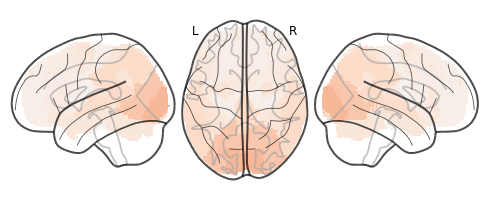

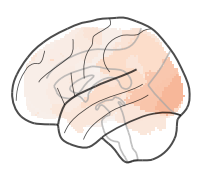

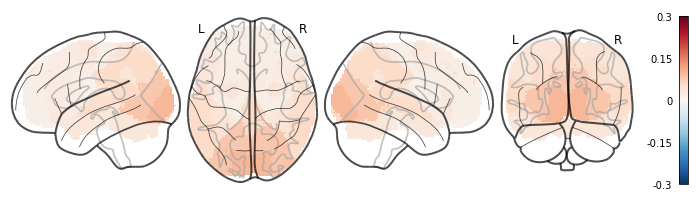

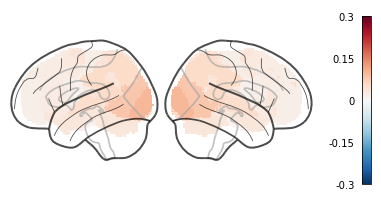

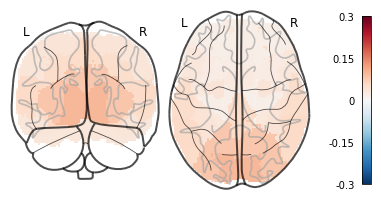

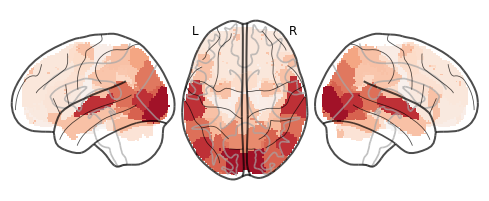

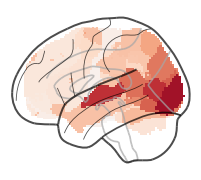

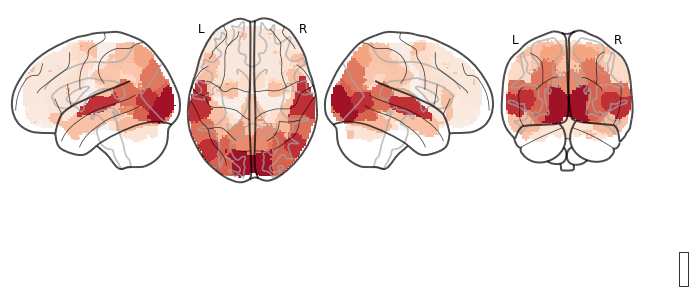

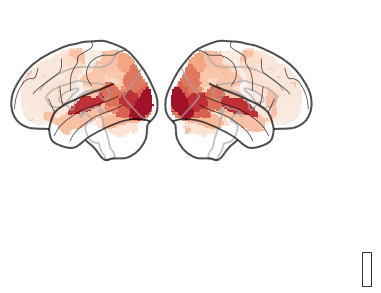

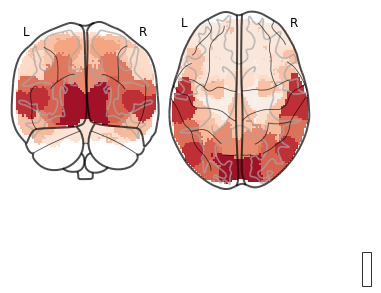

In [12]:
study = 'Study1'
episode = 'ep01'

cmap = 'RdBu_r'
vmax = .3
for analysis in ['Spatial_ISC','Spatial_ISC_Hyperaligned']:
    spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_{analysis}.csv'))
    spatial_isc_mean = roi_to_brain(spatial_isc.mean(), mask_x)

    plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='lzr',colorbar=False,cmap=cmap, plot_abs=False,vmax=vmax)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_{analysis}_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_{analysis}_Figure.png'), dpi=300)

    plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='l',colorbar=False,cmap=cmap, plot_abs=False,vmax=vmax)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Left_{analysis}_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Left_{analysis}_Figure.png'), dpi=300)

    plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='lzry',colorbar=True,cmap=cmap, plot_abs=False,vmax=vmax)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_{analysis}_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_{analysis}_Figure.png'), dpi=300)

    plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='lr',colorbar=True,cmap=cmap, plot_abs=False,vmax=vmax)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_{analysis}_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_{analysis}_Figure.png'), dpi=300)

    plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='yz',colorbar=True,cmap=cmap, plot_abs=False,vmax=vmax)
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Medial_{analysis}_Figure.pdf'))
    plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Medial_{analysis}_Figure.png'), dpi=300)

## Descriptive stats for paper

### Compute Temporal ISC for hyperalignment comparison

In [89]:
episode = 'ep01'
study = 'Study1'
all_stats = {}
for analysis in ['Denoised_ROI', 'Denoised_ROI_Hyperaligned']:
    for roi in [4, 32]:
        file_list = glob.glob(os.path.join(base_dir, 'Data', study, analysis, f'*{episode}*ROI{roi}.csv'))
        mn = {}
        for f in file_list:
            sub = os.path.basename(f).split('_')[0]
            dat = pd.read_csv(f)
            mn[sub] = dat.T.mean()
        mn = pd.DataFrame(mn)

        temporal_isc = Adjacency(1 - pairwise_distances(mn.T, metric='correlation'), matrix_type='Similarity')
        stats = temporal_isc.isc()
        all_stats[f'{study}_{roi}'] = stats
        print(f"{analysis}, ROI-{roi} Mean: {stats['isc']:.02}, p = {stats['p']}, std={temporal_isc.std():.02}")
        
        sns.heatmap(temporal_isc.squareform(), xticklabels=False, yticklabels=False, vmin=-1, vmax=1, square=True, cmap='RdBu_r', cbar=False)
        plt.savefig(os.path.join(base_dir,'Figures','ISC', f'SpatialISC_{analysis}_ROI{roi}_ISC.pdf'))
        plt.close()

Denoised_ROI, ROI-4 Mean: 0.39, p = 0.0001999600079984003, std=0.13
Denoised_ROI, ROI-32 Mean: 0.05, p = 0.002599480103979204, std=0.07
Denoised_ROI_Hyperaligned, ROI-4 Mean: 0.36, p = 0.0001999600079984003, std=0.12
Denoised_ROI_Hyperaligned, ROI-32 Mean: 0.018, p = 0.25834833033393323, std=0.06


### Compute Permutation test of differences of dynamic ISC using hyperalignment

In [87]:
study = 'Study1'

spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'))
spatial_isc_hyp = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))

for roi in [4, 32]:
    print(f"Anatomical - ROI{roi}, Mean ISC: {spatial_isc.iloc[:,roi].mean():.02}, std ISC: {spatial_isc.iloc[:,roi].std():.02}")
    print(f"Hyperaligned - ROI{roi}, Mean ISC: {spatial_isc_hyp.iloc[:,roi].mean():.02}, std ISC: {spatial_isc_hyp.iloc[:,roi].std():.02}")

    # Compute Differences
    all_bootstraps= []
    for i in range(5000):
        all_bootstraps.append(np.mean((np.random.choice([1,-1], spatial_isc_hyp.shape[0])*spatial_isc_hyp.iloc[:,roi]) - spatial_isc.iloc[:,roi]))

    obs_diff = np.mean(spatial_isc_hyp.iloc[:,roi] - spatial_isc.iloc[:,roi])
    p = _calc_pvalue(all_bootstraps, obs_diff, tail=2)
    print(f"Permutation Test - Mean Diff{obs_diff}, p = {p}")
    

Anatomical - ROI4, Mean ISC: 0.1, std ISC: 0.062
Hyperaligned - ROI4, Mean ISC: 0.25, std ISC: 0.19
Permutation Test - Mean Diff0.15164968042811847, p = 0.0001999600079984003
Anatomical - ROI32, Mean ISC: 0.015, std ISC: 0.031
Hyperaligned - ROI32, Mean ISC: 0.019, std ISC: 0.037
Permutation Test - Mean Diff0.0042259149996890025, p = 1.0


## Find areas where hyperalignment improves ISC
### Try simple paired samples sign flipping on dynamic ISC

In [8]:
n_bootstraps = 5000
study = 'Study1'
episode = 'ep01'

spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'))
spatial_isc_hyp = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))
roi_p = {}
for roi in range(50):
    all_bootstraps= []
    for i in range(5000):
        all_bootstraps.append(np.mean((np.random.choice([1,-1], spatial_isc_hyp.shape[0])*spatial_isc_hyp.iloc[:,roi]) - spatial_isc.iloc[:,roi]))
    obs_diff = np.mean(spatial_isc_hyp.iloc[:,roi] - spatial_isc.iloc[:,roi])
    roi_p[roi] = _calc_pvalue(all_bootstraps, obs_diff, tail=2)

fdr_thr = fdr(np.array(list(roi_p.values())))
sig_roi = np.array(list(roi_p.keys()))[np.array(list(roi_p.values()) < fdr_thr)]

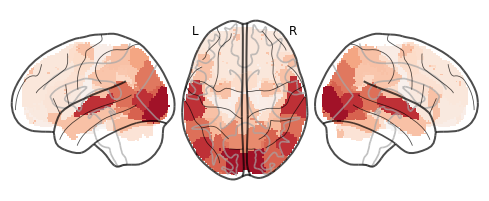

In [11]:
study = 'Study1'
episode = 'ep01'
vmax=.3
cmap='RdBu_r'

spatial_isc = pd.read_csv(os.path.join(base_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))
spatial_isc_mean = roi_to_brain(spatial_isc.mean(), mask_x)

display = plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='lzr',colorbar=False,cmap=cmap, plot_abs=False,vmax=vmax)
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_{analysis}_Figure.pdf'))
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_{analysis}_Figure.png'), dpi=300)


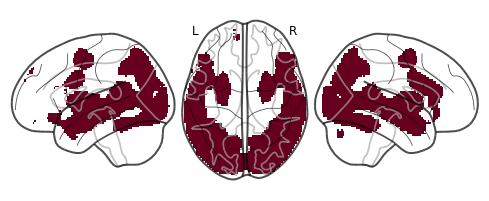

In [10]:
thresholded = Brain_Data([mask_x[x] for x in sig_roi]).sum()
plot_glass_brain(thresholded.to_nifti(),display_mode='lzr',colorbar=False,cmap=cmap, plot_abs=False,vmax=vmax)
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_Hyperalignment_Significance_Binary.pdf'))
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_Hyperalignment_Significance_Binary.png'), dpi=300)


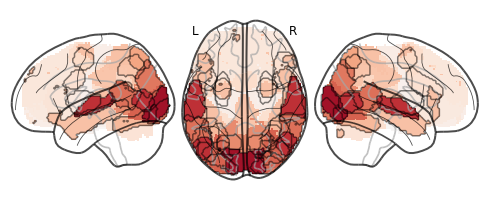

In [9]:

display = plot_glass_brain(spatial_isc_mean.to_nifti(),display_mode='lzr',colorbar=False,cmap=cmap, plot_abs=False,vmax=vmax)
[display.add_contours(mask_x[x].to_nifti(), levels=[0.5], colors='black', alpha=.5) for x in sig_roi]
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_Hyperalignment_Significance_Figure.pdf'))
plt.savefig(os.path.join(base_dir,'Figures','ISC', f'Spatial_ISC_Brain_Lateral_Medial_Hyperalignment_Significance_Figure.png'), dpi=300)


In [ ]:
for study in ['Study1', 'Study2']:
    with sns.plotting_context(context='paper', font_scale=2):
        fig, ax = plt.subplots(figsize=(0.5, 6))
        fig.subplots_adjust(bottom=0)

        cmap = mpl.cm.Reds
        norm = mpl.colors.Normalize(vmin=0, vmax=max_time[study])
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', ticks=np.linspace(0, max_time[study], 5))
        plt.tight_layout()
        plt.savefig(os.path.join(base_dir,'Figures','Autocorrelation', f'{study}_Spatial_Autocorrelation_Colorbar_Vertical.pdf'))


# Is ISC higher in time points of higher vmPFC state concordance?

In [73]:
base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
data_dir = '/Volumes/Engram/Data/vmpfc/'
study = 'Study1'

version = 'v3'
analysis = f'HMM_Combined_{version}'
cf_version = 'v3'
var_exp = .9
dilate_samples = 60
episode = 'ep01'

# Load Concordances
vmpfc_s1_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study1_{episode}_k4_ROI32_{version}.csv'), index_col=0))
vmpfc_s1_concordance.columns = [f'Study1_ROI32_{x}' for x in vmpfc_s1_concordance.columns]
vmpfc_s2_concordance = create_average_concordance(pd.read_csv(os.path.join(base_dir,'Analyses', analysis, f'HMM_PredictedStates_Study2_{episode}_k4_ROI32_{version}.csv'), index_col=0))
vmpfc_s2_concordance.columns = [f'Study2_ROI32_{x}' for x in vmpfc_s2_concordance.columns]

vmpfc_s1_remapping = {'State_0':'State_1','State_1':'State_3','State_2':'State_2','State_3':'State_0'}
vmpfc_s1_concordance.columns = [f"Study1_ROI32_{vmpfc_s1_remapping[x.split('ROI32_')[1]]}" for x in vmpfc_s1_concordance.columns]
vmpfc_s1_concordance = vmpfc_s1_concordance.iloc[:,[3,0,2,1]]

v1_s2_remapping = {f'State_{i}':f'State_{x}' for i,x in enumerate(align_states(v1_s1_concordance, v1_s2_concordance, return_index=True))}
vmpfc_s2_remapping = {f'State_{i}':f'State_{x}' for i,x in enumerate(align_states(vmpfc_s1_concordance, vmpfc_s2_concordance, return_index=True))}
vmpfc_s2_concordance.columns = [f"Study2_ROI32_{vmpfc_s2_remapping[x.split('ROI32_')[1]]}" for x in vmpfc_s2_concordance.columns]
concordance = pd.concat([vmpfc_s1_concordance, vmpfc_s2_concordance], axis=1)



In [77]:
roi = 32
thresh = 0.7
n_permute = 5000
k = 4

base_dir = '/Users/lukechang/Dropbox/TV_fMRI/'
data_dir = '/Volumes/Engram/Data/vmpfc/'

state_spatial_similarity = []
for study in ['Study1', 'Study2']:
    # Hyperaligned Spatial ISC
    spatial_isc = pd.read_csv(os.path.join(data_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC.csv'))
#     spatial_isc = pd.read_csv(os.path.join(data_dir, 'Analyses', 'ISC', f'{study}_{episode}_Spatial_ISC_Hyperaligned.csv'))

    for state in [f'State_{x}' for x in range(k)]:
        # Create Contrast
        state_on = spatial_isc.iloc[:,roi][concordance[f'{study}_ROI{roi}_{state}'] >= thresh].mean()
        state_off = spatial_isc.iloc[:,roi][concordance[f'{study}_ROI{roi}_{state}'] < thresh].mean()
        state_on_std = spatial_isc.iloc[:,roi][concordance[f'{study}_ROI{roi}_{state}'] >= thresh].std()
        state_off_std = spatial_isc.iloc[:,roi][concordance[f'{study}_ROI{roi}_{state}'] < thresh].std()
        contrast = state_on - state_off

        # Create Null Distribution
        null = []
        for i in range(n_permute):
            spatial_isc_shifted = circle_shift(spatial_isc.iloc[:,roi])
            state_on_shifted = spatial_isc_shifted[concordance[f'{study}_ROI{roi}_{state}'] >= thresh].mean()
            state_off_shifted = spatial_isc_shifted[concordance[f'{study}_ROI{roi}_{state}'] < thresh].mean()
            contrast_shifted = state_on_shifted - state_off_shifted
            null.append(contrast_shifted)              
        p = _calc_pvalue(np.array(null), contrast, tail=2)
        state_spatial_similarity.append({'State':state,'Study':study, 'ROI':roi,
                                         'StateOnVOff':contrast, 'p':p,
                                         'StateOn_Mean':state_on,'StateOff_Mean':state_off,
                                         'StateOn_Std':state_on_std,'StateOff_Std':state_off_std})
state_spatial_similarity = pd.DataFrame(state_spatial_similarity)
state_spatial_similarity.to_csv(os.path.join(data_dir, 'Analyses','ISC','State_Spatial_Similarity_Contrast.csv'))

state_spatial_similarity


,State,Study,ROI,StateOnVOff,p,StateOn_Mean,StateOff_Mean,StateOn_Std,StateOff_Std
0,State_0,Study1,32,0.011012,0.127574,0.025684,0.014672,0.036714,0.031173
1,State_1,Study1,32,0.013173,0.124175,0.027786,0.014613,0.046422,0.030844
2,State_2,Study1,32,NaN,0.000200,NaN,0.014922,NaN,0.031337
3,State_3,Study1,32,NaN,0.000200,NaN,0.014922,NaN,0.031337
4,State_0,Study2,32,0.116884,0.000600,0.144387,0.027503,0.095420,0.027645
5,State_1,Study2,32,0.006581,0.611278,0.034212,0.027631,0.016753,0.028163
6,State_2,Study2,32,NaN,0.000200,NaN,0.027675,NaN,0.028104
7,State_3,Study2,32,NaN,0.000200,NaN,0.027675,NaN,0.028104
